# Information spread in social networks


In this notebook we will explore an example network and simulate information spread using the independent cascade model.


In [64]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from collections import Counter
import sys
import os
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

##### Loading the datasets

In [65]:
import pandas as pd
source = []
for i in range(2):
    source.append(pd.read_csv('data/SN{}-edges.csv'.format(i+1)))

In [66]:
all_source = pd.concat(source)

In [67]:
all_source.head()

,Source,Target,Type,weight,place
0,Georgiana-Sala,Stefan-Leonte,Undirected,3,1.0
1,Georgiana-Sala,Timon-Lascu,Undirected,6,1.0
2,Natalia-Constantin,Veronica-Matei,Undirected,5,1.0
3,Natalia-Constantin,Mihai-Constantin,Undirected,4,1.0
4,Isabela-Lupu,Sabina-Petran,Undirected,4,1.0


In [68]:
edges = all_source.groupby(['Source','Target']).agg({'weight':'sum'}).reset_index()

In [69]:
edges.sort_values('weight',ascending=False).head()

,Source,Target,weight
776,Mihai-Constantin,Robert-Antonescu,317
628,Marcian-Manole,Sorina-Sicoe,163
75,Astrid-Dragan,Corina-Filip,144
685,Marius-Cojocaru,Luiza-Dinu,140
210,Corina-Filip,Samuel-Tudose,133


In [70]:
import networkx as nx
Network = nx.from_pandas_edgelist(edges, 
                            source='Source',
                            target='Target',
                            edge_attr='weight' )

In [71]:
print(nx.info(Network))

Name: 
Type: Graph
Number of nodes: 362
Number of edges: 1250
Average degree:   6.9061


In [72]:
weighted_degrees = dict(nx.degree(Network,weight='weight'))
max_degree = max(weighted_degrees.values())

In [73]:
import seaborn as sns

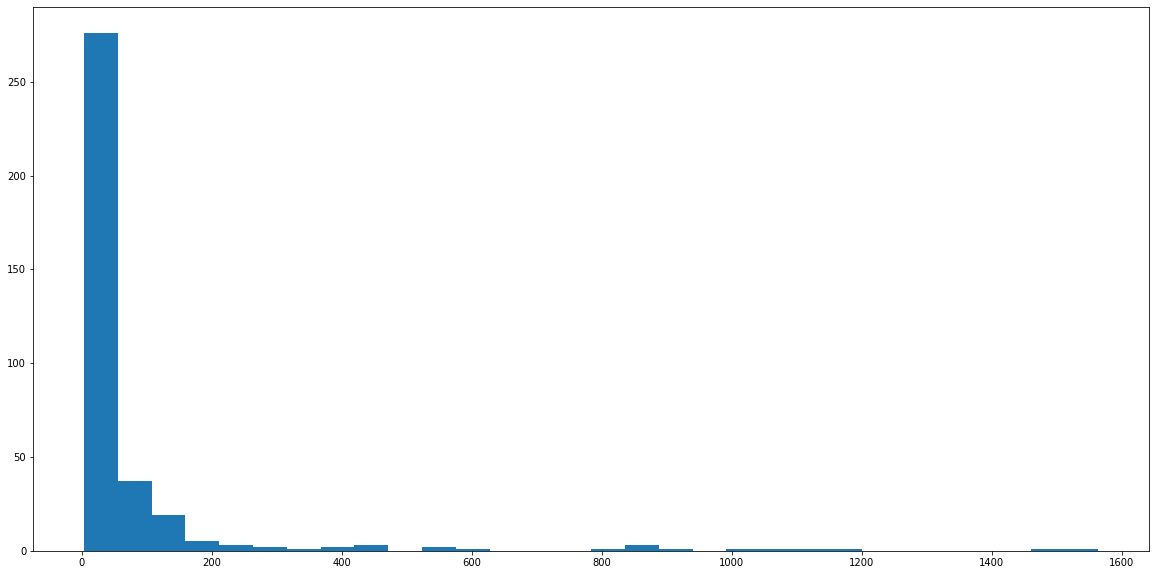

In [74]:
import matplotlib.pyplot as plt
h = plt.hist(weighted_degrees.values(), bins = 30)

### Subnetwork of key individuals:

In [75]:
subG = Network.subgraph([n for n in weighted_degrees if weighted_degrees[n]>200])

In [76]:
print(nx.info(subG))

Name: 
Type: Graph
Number of nodes: 26
Number of edges: 180
Average degree:  13.8462


In [77]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

### Let's plot the network:

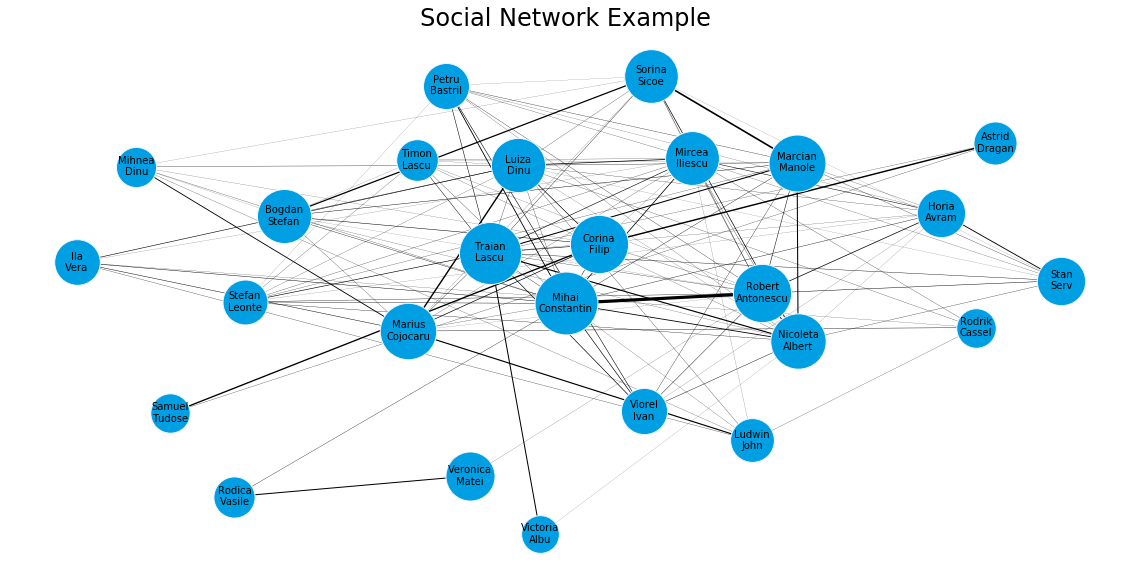

In [78]:
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
plt.axis('off')
plt.title('Social Network Example',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>100},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='black')

### The example network with nodes colored by Degree and sized by Betweeness Centrality:

(-0.822906979623931,
 0.6639367703609723,
 -1.092109092587247,
 0.6514626886467203)

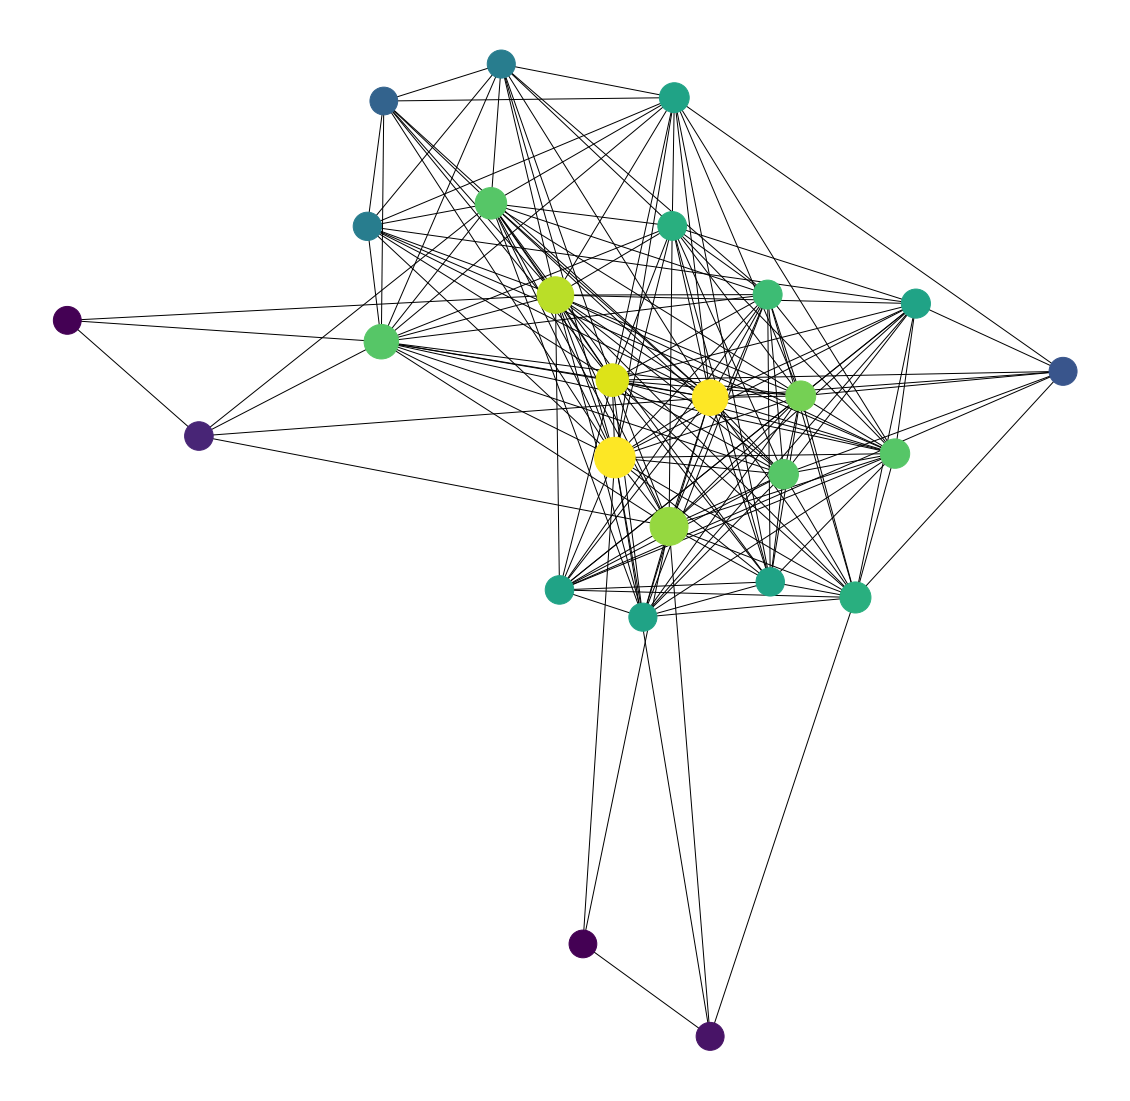

In [79]:
pos = nx.spring_layout(subG)
betCent = nx.betweenness_centrality(subG, normalized=True, endpoints=True)
node_color = [20000.0 * subG.degree(v) for v in subG]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(subG, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [58]:
infection_times = {}

### Let's simulate the independent cascade model:

In [59]:
def independent_cascade(G,t,infection_times):
    #doing a t->t+1 step of independent_cascade simulation
    #each infectious node infects neigbors with probabilty proportional to the weight
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    infection_times[v] = t+1
    return infection_times

In [60]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Information Diffusion, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#f2f6fa')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')


In [61]:
infection_times = {'Mihai-Constantin':-1,'Marius-Cojocaru':-1, 'Corina-Filip':0}

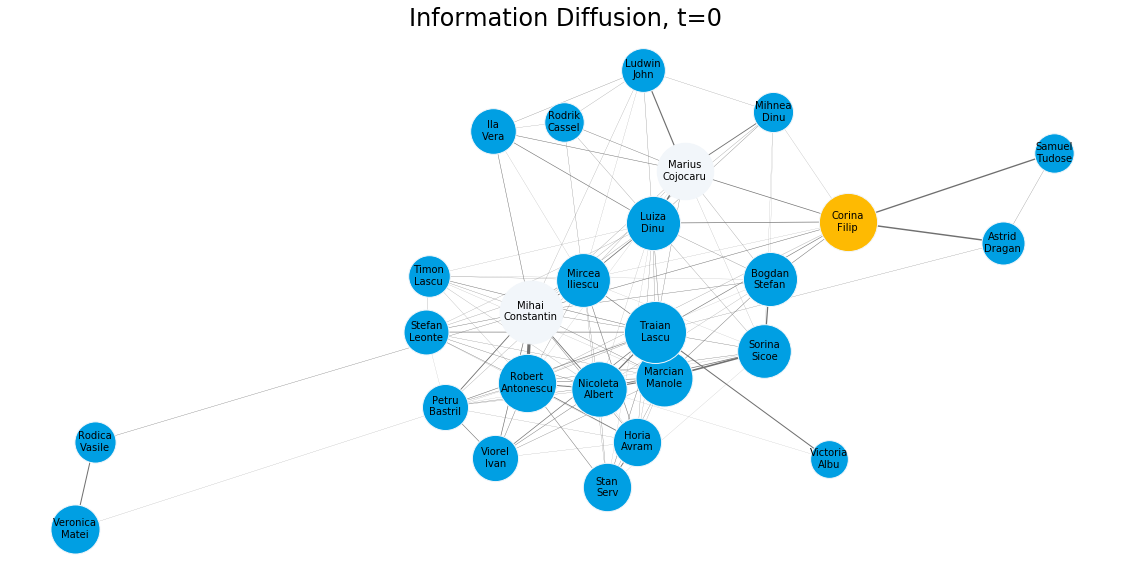

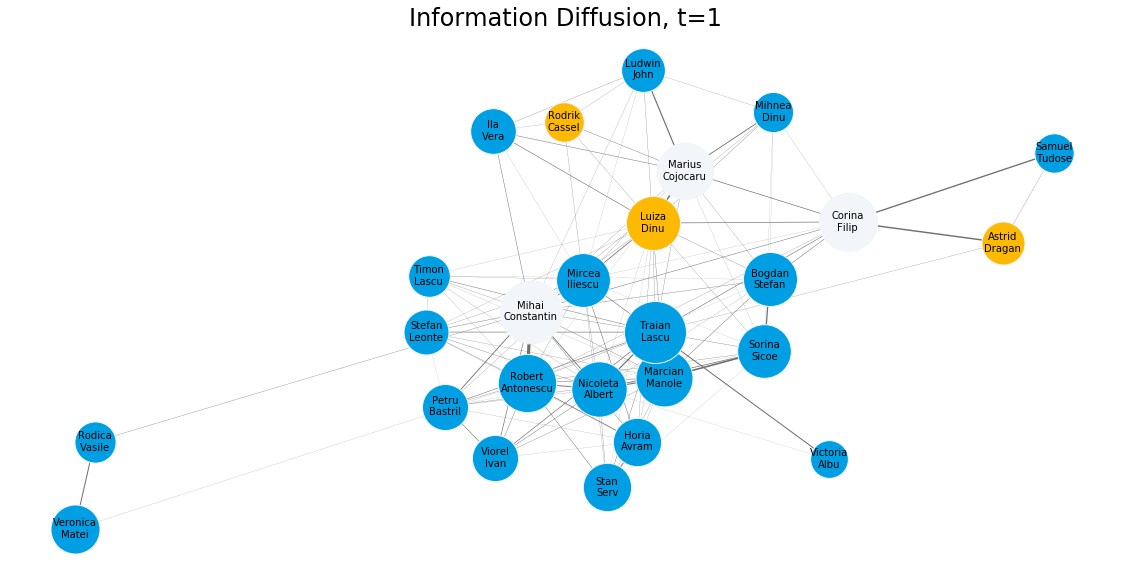

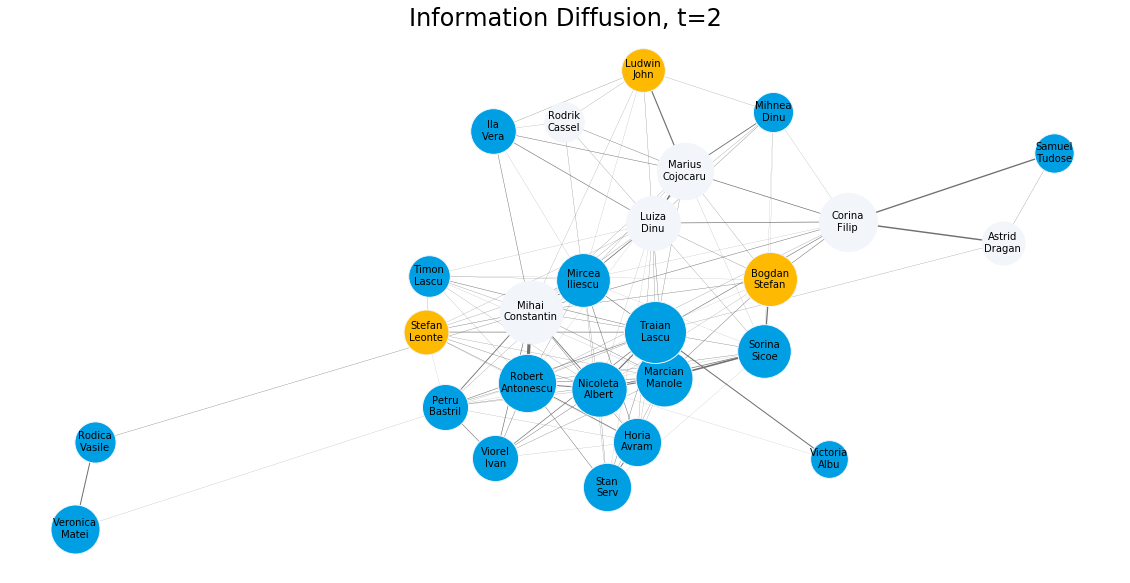

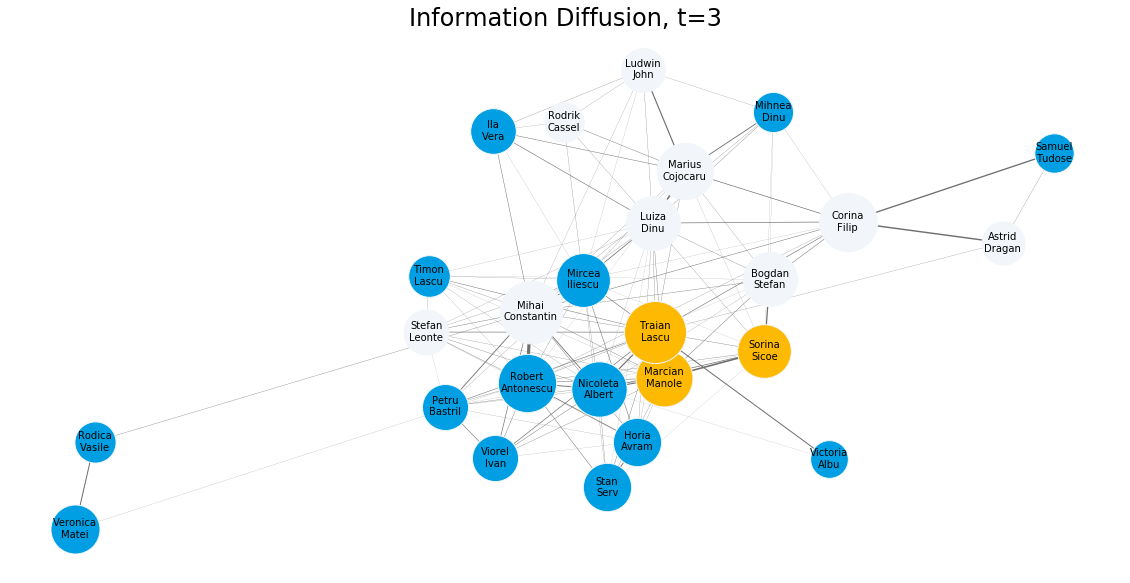

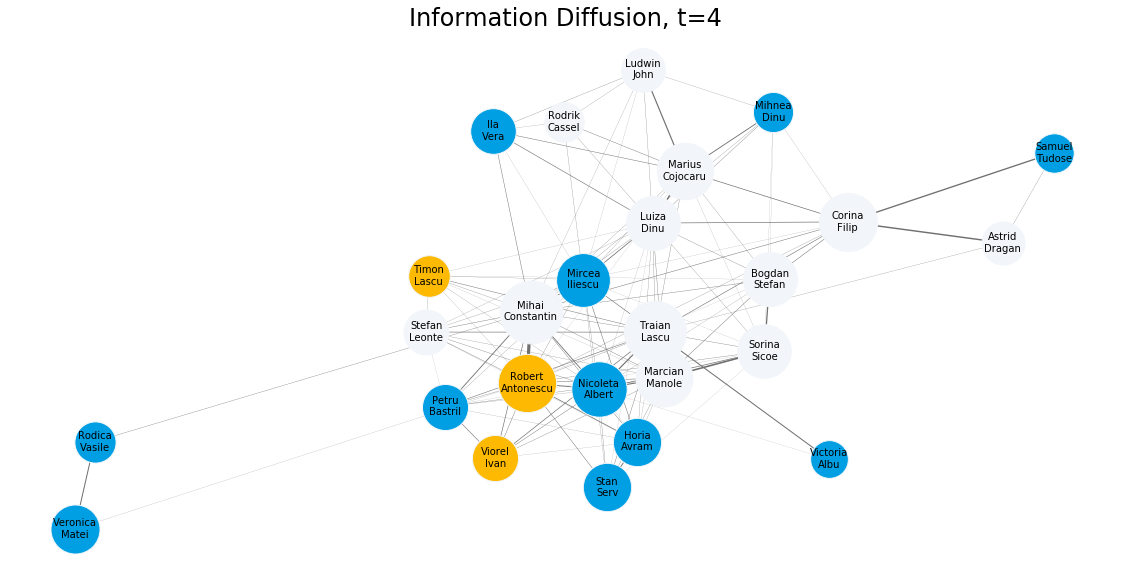

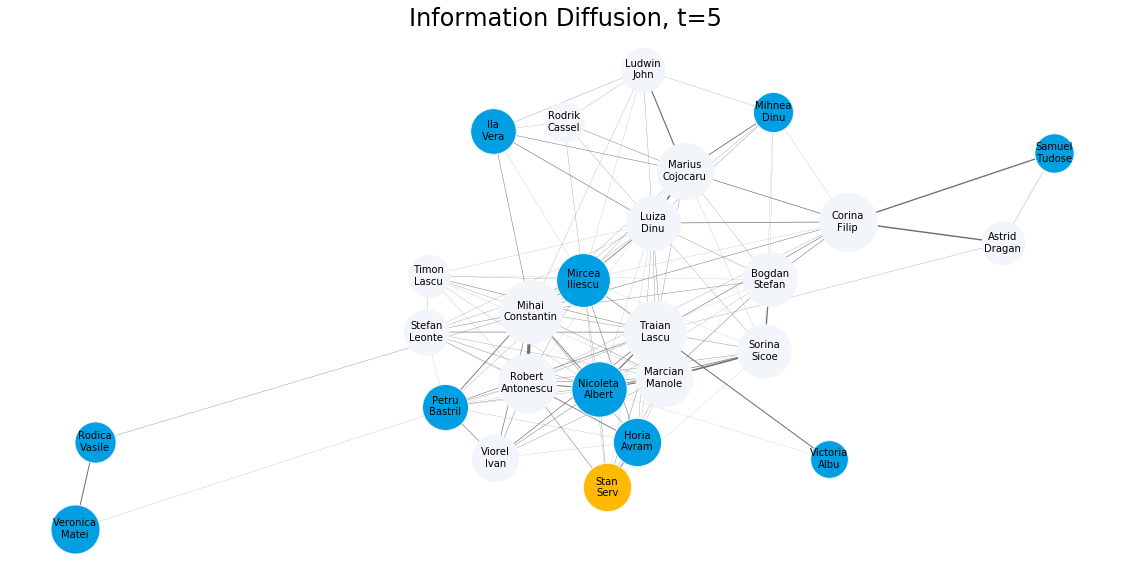

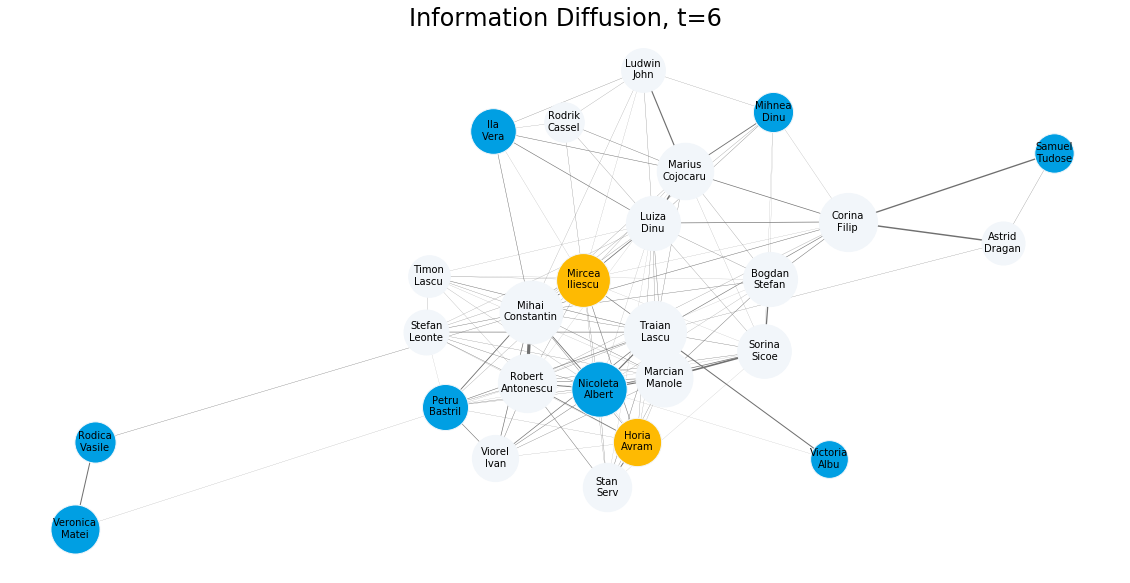

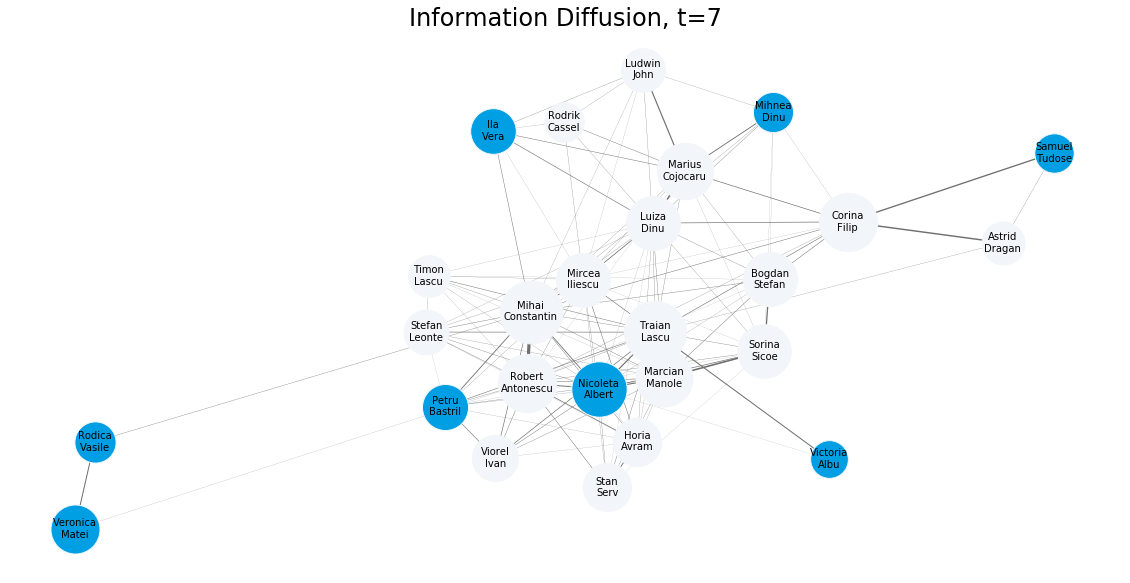

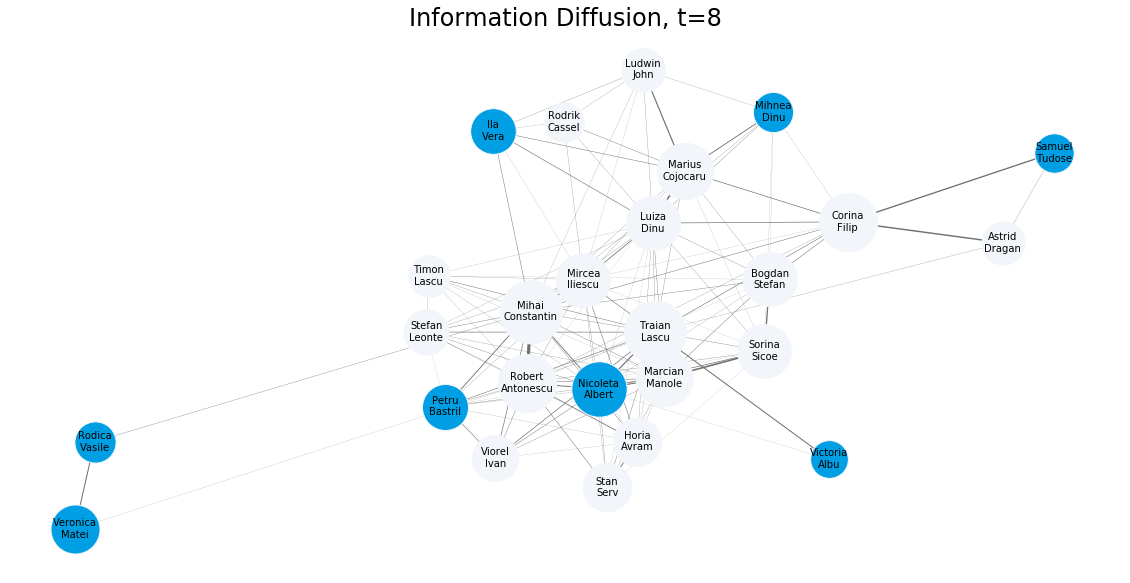

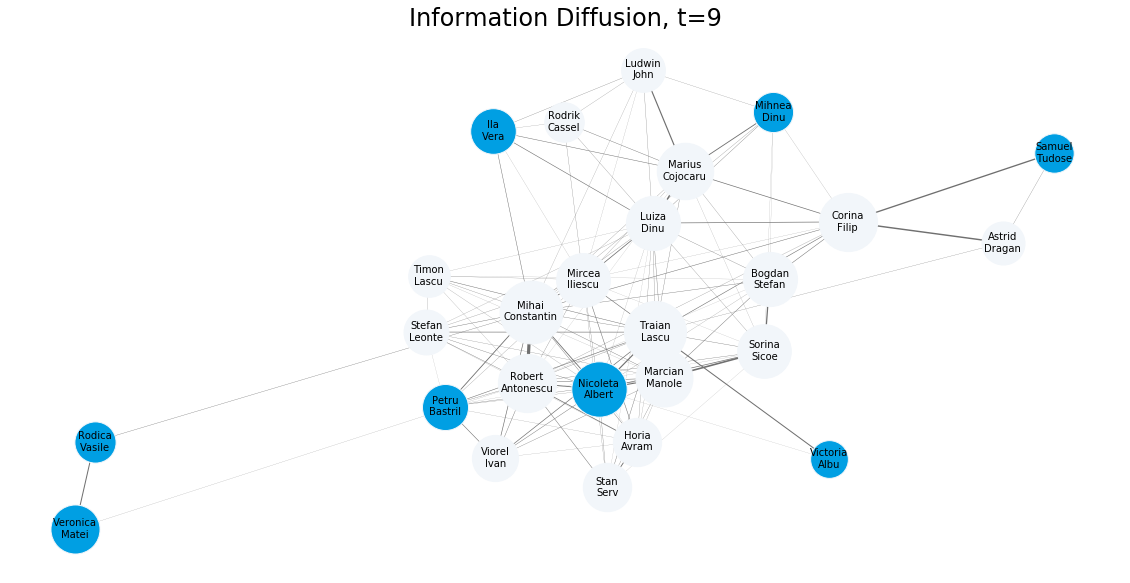

In [62]:
import numpy as np
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade(subG,t,infection_times)

#### Key actors in the network

In [80]:
sorted(betCent, key=betCent.get, reverse=True)[:5]

['Mihai-Constantin',
 'Robert-Antonescu',
 'Luiza-Dinu',
 'Traian-Lascu',
 'Corina-Filip']

In [81]:
degCent = nx.degree_centrality(subG)
sorted(degCent, key=degCent.get, reverse=True)[:5]

['Traian-Lascu',
 'Mihai-Constantin',
 'Mircea-Iliescu',
 'Luiza-Dinu',
 'Robert-Antonescu']

In [82]:
eigCent = nx.eigenvector_centrality(subG)
sorted(eigCent, key=eigCent.get, reverse=True)[:5]

['Traian-Lascu',
 'Mircea-Iliescu',
 'Mihai-Constantin',
 'Luiza-Dinu',
 'Marcian-Manole']